# Exploring Machine Learning on Quantopian
Recently, Quantopian’s Chief Investment Officer, Jonathan Larkin, shared an industry insider’s overview of the [professional quant equity workflow](http://blog.quantopian.com/a-professional-quant-equity-workflow/). This workflow is comprised of distinct stages including: (1) Universe Definition, (2) Alpha Discovery, (3) Alpha Combination, (4) Portfolio Construction and (5) Trading.

This Notebook focuses on stage 3: Alpha Combination. At this stage, Machine Learning is an intuitive choice as we have abstracted the problem to such a degree that it is now a classic classification (or regression) problem which ML is very good at solving and coming up with an alpha combination that is predictive.

As you will see, there is a lot of code here setting up a factor library and some data wrangling to get everything into shape. The details of this part are perhaps not quite as interesting so feel free to skip directly to ["Training our ML pipeline"](#training) where we have everything in place to train and test our classifier.

## Overview
1. Define trading universe to use ([Q500US and Q1500US](https://www.quantopian.com/posts/the-q500us-and-q1500us)).
2. Define alphas (implemented in [Pipeline](https://www.quantopian.com/tutorials/pipeline)).
3. Run pipeline.
4. Split into train and test set.
5. Preprocess data (rank alphas, subsample, align alphas with future returns, impute, scale).
6. Train Machine Learning classifier ([AdaBoost from Scikit-Learn](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)).
7. Evaluate Machine Learning classifier on test set.

Note that one important limitation is that we only train and test on static (i.e. fixed-in-time) data. Thus, you can not directly do the same in an algorithm. In principle, this is possible and will be the next step but it makes sense to first focus on just the ML in a more direct way to get a good intuition about the workflow and how to develop a competitive ML pipeline.

### Disclaimer
This workflow is still a bit rough around the edges. We are working on improving it and adding better educational materials. This serves as a sneak-peek for the curious and adventurous.

# https://machinelearningmastery.com/feature-selection-machine-learning-python/

In [1]:
from quantopian.research import run_pipeline
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import Latest
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.data import morningstar
from quantopian.pipeline.factors import (
    AnnualizedVolatility,
    Aroon, # not working here
    AverageDollarVolume,
    BollingerBands,
    FastStochasticOscillator,
    MarketCap,
    MovingAverageConvergenceDivergenceSignal,
    TrueRange,
    VWAP,
    WeightedAverageValue,
    CustomFactor,
    SimpleMovingAverage,
    AverageDollarVolume,
    Returns,
    RSI,
    EWMA
        
)
from quantopian.pipeline.classifiers.morningstar import Sector
from quantopian.pipeline.filters import Q500US, Q1500US
from quantopian.pipeline.data.quandl import fred_usdontd156n as libor
from quantopian.pipeline.data.zacks import EarningsSurprises

import talib
import pandas as pd
import numpy as np
from time import time

import alphalens as al
import pyfolio as pf
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import linear_model, decomposition, ensemble, preprocessing, isotonic, metrics

## Definition of some commonly used factors
The factors below are a small collection of commonly used alphas that were coded by Gil Wassermann. I will post a separate Notebook with the full collection and more descriptions of them. Ultimately we will put these into a library you can just import to avoid the wall of text. If you want to understand more about pipeline, read the [tutorial](https://www.quantopian.com/tutorials/pipeline).

Also note the `Earnings_Quality` alpha which uses [Zacks Earnings Surprises](https://www.quantopian.com/data/zacks/earnings_surprises), a [new source from our partners](https://www.quantopian.com/data).

The details of these factors are not the focus of this Notebook so feel free to just [skip](#universe) this cell.

In [2]:
bs = morningstar.balance_sheet
cfs = morningstar.cash_flow_statement
is_ = morningstar.income_statement
or_ = morningstar.operation_ratios
er = morningstar.earnings_report
v = morningstar.valuation
vr = morningstar.valuation_ratios


def make_factors():
    
    
    def Asset_Growth_3M():
        return Returns(inputs=[bs.total_assets], window_length=63)

    def Asset_To_Equity_Ratio():
        return bs.total_assets.latest / bs.common_stock_equity.latest

    def Capex_To_Cashflows():
        return (cfs.capital_expenditure.latest * 4.) / \
            (cfs.free_cash_flow.latest * 4.)
        
    def EBITDA_Yield():
        return (is_.ebitda.latest * 4.) / \
            USEquityPricing.close.latest        

    def EBIT_To_Assets():
        return (is_.ebit.latest * 4.) / \
            bs.total_assets.latest
        
    def Earnings_Quality():
        return morningstar.cash_flow_statement.operating_cash_flow.latest / \
               EarningsSurprises.eps_act.latest
        
    def Return_On_Total_Invest_Capital():
        return or_.roic.latest
    
    class Mean_Reversion_1M(CustomFactor):
        inputs = [Returns(window_length=21)]
        window_length = 252

        def compute(self, today, assets, out, monthly_rets):
            out[:] = (monthly_rets[-1] - np.nanmean(monthly_rets, axis=0)) / \
                np.nanstd(monthly_rets, axis=0)
                
    class MACD_Signal_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    _, signal_line, _ = talib.MACD(col, fastperiod=12,
                                                   slowperiod=26, signalperiod=10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines 
            
    # THESE ARE MY CUSTOM TALIB FACTORS
    
    

    """
    HELPER FUNCTIONS
    """

    def plus_dm_helper(high, low):
        """
        Returns positive directional movement. Abstracted for use with more complex factors

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI

        Parameters
        ----------
        high : np.array
            matrix of high prices
        low : np.array
            matrix of low prices

        Returns
        -------
        np.array : matrix of positive directional movement

        """
        # get daily differences between high prices
        high_diff = (high - np.roll(high, 1, axis=0))[1:]

        # get daily differences between low prices
        low_diff = (np.roll(low, 1, axis=0) - low)[1:]

        # matrix of positive directional movement
        return np.where(((high_diff > 0) | (low_diff > 0)) & (high_diff > low_diff), high_diff, 0.)

    def minus_dm_helper(high, low):
        """
        Returns negative directional movement. Abstracted for use with more complex factors

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI

        Parameters
        ----------
        high : np.array
            matrix of high prices
        low : np.array
            matrix of low prices

        Returns
        -------
        np.array : matrix of negative directional movement

        """
        # get daily differences between high prices
        high_diff = (high - np.roll(high, 1, axis=0))[1:]

        # get daily differences between low prices
        low_diff = (np.roll(low, 1, axis=0) - low)[1:]

        # matrix of megative directional movement
        return np.where(((high_diff > 0) | (low_diff > 0)) & (high_diff < low_diff), low_diff, 0.)


    def trange_helper(high, low, close):
        """
        Returns true range

        http://www.macroption.com/true-range/

        Parameters
        ----------
        high : np.array
            matrix of high prices
        low : np.array
            matrix of low prices
        close: np.array
            matrix of close prices

        Returns
        -------
        np.array : matrix of true range

        """
        # define matrices to be compared
        close = close[:-1]
        high = high[1:]
        low = low[1:]

        # matrices for comparison
        high_less_close = high - close
        close_less_low = close - low
        high_less_low = high - low

        # return maximum value for each cel
        return np.maximum(high_less_close, close_less_low, high_less_low)


    """
    Techincal Analysis Indicators
    """


    class AD(CustomFactor):
        """
        Chaikin Accumulation Distribution Line

        Volume indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low, USEquitypricing.close, USEquityPricing.volume

        **Default Window Length:** 14

        http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:accumulation_distribution_line
        """	    
        inputs = [USEquityPricing.close, USEquityPricing.high, USEquityPricing.low, USEquityPricing.volume]
        window_length = 14

        def compute(self, today, assets, out, close, high, low, vol):

            # close location value
            clv = ((close - low) - (high - close)) / (high - low)
            ad = clv * vol
            out[:] =  np.sum(ad, axis=0)


    class ADX(CustomFactor):
        """
        Average Directional Movement Index

        Momentum indicator. Smoothed DX

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low, USEquitypricing.close

        **Default Window Length:** 29

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI
        """	    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 29

        def compute(self, today, assets, out, high, low, close):

            # positive directional index
            plus_di = 100 * np.cumsum(plus_dm_helper(high, low) / trange_helper(high, low, close), axis=0)

            # negative directional index
            minus_di = 100 * np.cumsum(minus_dm_helper(high, low) / trange_helper(high, low, close), axis=0)

            # full dx with 15 day burn-in period
            dx_frame = (np.abs(plus_di - minus_di) / (plus_di + minus_di) * 100.)[14:]

            # 14-day EMA
            span = 14.
            decay_rate = 2. / (span + 1.)
            weights = weights_long = np.full(span, decay_rate, float) ** np.arange(span + 1, 1, -1)

            # return EMA
            out[:] = np.average(dx_frame, axis=0, weights=weights)


    def APO(shortperiod=12, longperiod=26):
        """
        Absolute Price Oscillator

        Momentum indeicator. Difference between EWMAs (exponential weighted moving averages) of 
        short and long periods.

        **Default Inputs:** 12, 26

        **Default Window Length:** 46 (26 + 20-day burn-in)

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/apo

        Parameters
        ----------
        shortperiod : int > 0
            window length for short EWMA
        longperiod : int > 0 (>= shortperiod)
            window length for longer EWMA

        Returns
        -------
        zipline.Factor
        """
        buffer_window = longperiod + 20

        fast = EWMA.from_span(inputs=[USEquityPricing.close], window_length=buffer_window, span=shortperiod)
        slow = EWMA.from_span(inputs=[USEquityPricing.close], window_length=buffer_window, span=longperiod) 
        return fast - slow


    class ATR(CustomFactor):
        """
        Average True Range

        Momentum indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 15 (14+1)

        https://en.wikipedia.org/wiki/Average_true_range
        """
        inputs=[USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 15

        def compute(self, today, assets, out, high, low, close):

            tr_frame = trange_helper(high, low, close)
            decay_rate= 2./(len(tr_frame) + 1.)
            weights = np.full(len(tr_frame), decay_rate, float) ** np.arange(len(tr_frame) + 1, 1, -1)
            out[:] = np.average(tr_frame, axis=0, weights=weights)


    class BETA(CustomFactor):
        """
        Market Beta (returns)

        **Default Inputs:** USEquityPricing.close

        **Default Window Length:** 6

        https://en.wikipedia.org/wiki/Beta_(finance)
        """

        inputs=[USEquityPricing.close]
        window_length = 6

        def compute(self, today, assets, out, close):

            # get returns dataset
            returns = ((close - np.roll(close, 1, axis=0)) / np.roll(close, 1, axis=0))[1:]

            # get index of benchmark
            benchmark_index = np.where((assets == 8554) == True)[0][0]

            # get returns of benchmark
            benchmark_returns = returns[:, benchmark_index]

            # prepare X matrix (x_is - x_bar)
            X = benchmark_returns
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(returns.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (len(returns), 1))
            Y_matrix = returns - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / (len(returns))


    class BOP(CustomFactor):
        """
        Balance of Power

        Momentum indicator

        **Default Inputs:** USEquityPricing.close, USEquityPricing.open, USEquityPricing.high, USEquityPricing.low

        **Default Window Length:** 1

        https://www.interactivebrokers.com/en/software/tws/usersguidebook/technicalanalytics/balancepower.htm
        """
        inputs = [USEquityPricing.close, USEquityPricing.open, USEquityPricing.high, USEquityPricing.low]
        window_length = 1

        def compute(self, today, assets, out, close, open, high, low):
            out[:] = (close - open) / (high - low)


    class CCI(CustomFactor):
        """
        Commodity Channel Index

        Momentum indicator

        **Default Inputs:** USEquityPricing.close, USEquityPricing.high, USEquityPricing.low

        **Default Window Length:** 14

        http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:commodity_channel_index_cci
        """

        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 14

        def compute(self, today, assets, out, high, low, close):

            # typical price matrix
            typical_prices = (high + low + close) / 3.

            # mean of each column
            mean_typical = np.nanmean(typical_prices, axis=0)

            # mean deviation
            mean_deviation = np.sum(np.abs(typical_prices - np.tile(mean_typical, (len(typical_prices), 1))), axis=0) / self.window_length

            # CCI
            out[:] = (typical_prices[-1] - mean_typical) / (.015 * mean_deviation)


    class CMO(CustomFactor):
        """
        Chande Momentum Oscillator

        Momentum indicator. Descriptor of overought/oversold conditions

        **Default Inputs:** USEquityPricing.close

        **Default Window Length:** 15 (14 + 1-day for differences)

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/cmo
        """
        inputs=[USEquityPricing.close]
        window_length = 15

        def compute(self, today, assets, out, close):

            # daily differences in close prices
            close_diff = (close - np.roll(close, 1, axis=0))[1:]

            # close differences on up days
            su = np.sum(np.where(close_diff > 0, close_diff, 0), axis=0)

            # absolute value of close differences on down days
            sd = np.abs(np.sum(np.where(close_diff < 0, close_diff, 0), axis=0))

            # CMO
            out[:] = 100 * (su - sd) / (su + sd)


    class DX(CustomFactor):
        """
        Directional Movement Index

        Momentum indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low, USEquitypricing.close

        **Default Window Length:** 15

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI
        """	    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 15

        def compute(self, today, assets, out, high, low, close):

            # positive directional index
            plus_di = 100 * np.sum(plus_dm_helper(high, low) / (trange_helper(high, low, close)), axis=0)

            # negative directional index
            minus_di = 100 * np.sum(minus_dm_helper(high, low) / (trange_helper(high, low, close)), axis=0)

            # DX
            out[:] = np.abs(plus_di - minus_di) / (plus_di + minus_di) * 100.


    class LINEARREG_SLOPE(CustomFactor):
        """
        Slope of Trendline

        Momentum indicator.

        **Default Inputs:**  USEquitypricing.close

        **Default Window Length:** 14

        http://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf
        """	    
        inputs=[USEquityPricing.close]
        window_length=14

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / (self.window_length)


    class LINEARREG_INTERCEPT(CustomFactor):
        """
        Intercept of Trendline

        **Default Inputs:**  USEquitypricing.close

        **Default Window Length:** 14

        http://www.stat.cmu.edu/~cshalizi/mreg/15/lectures/06/lecture-06.pdf
        """
        inputs=[USEquityPricing.close]
        window_length=14

        # using MLE
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y vectors (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            betas = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / (self.window_length)

            # now use to get to MLE of alpha
            out[:] = Y_bar - (betas * X_bar)


    class MAX(CustomFactor):
        """
        Maximum value for each column of a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            # get vector of maximums
            out[:] = np.nanmax(data, axis=0)


    class MAXINDEX(CustomFactor):
        """
        Index of maximum value for each column of a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            # get vector of indices
            out[:] = np.argmax(data, axis=0)


    class MEDPRICE(CustomFactor):
        """
        Mean of a day's high and low prices

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low

        **Default Window Length:** 1

        http://www.fmlabs.com/reference/default.htm?url=MedianPrices.htm
        """	    
        inputs = [USEquityPricing.high, USEquityPricing.low]
        window_length = 1

        def compute(self, today, assets, out, high, low):
            out[:] = (high + low) / 2.


    class MFI(CustomFactor):
        """
        Money Flow Index

        Volume Indicator

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low, USEquityPricing.close, USEquityPricing.volume

        **Default Window Length:** 15 (14 + 1-day for difference in prices)

        http://www.fmlabs.com/reference/default.htm?url=MoneyFlowIndex.htm
        """	    

        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close, USEquityPricing.volume]
        window_length = 15

        def compute(self, today, assets, out, high, low, close, vol):

            # calculate typical price
            typical_price = (high + low + close) / 3.

            # calculate money flow of typical price
            money_flow = typical_price * vol

            # get differences in daily typical prices
            tprice_diff = (typical_price - np.roll(typical_price, 1, axis=0))[1:]

            # create masked arrays for positive and negative money flow
            pos_money_flow = np.ma.masked_array(money_flow[1:], tprice_diff < 0, fill_value = 0.)
            neg_money_flow = np.ma.masked_array(money_flow[1:], tprice_diff > 0, fill_value = 0.)

            # calculate money ratio
            money_ratio = np.sum(pos_money_flow, axis=0) / np.sum(neg_money_flow, axis=0)

            # MFI
            out[:] = 100. - (100. / (1. + money_ratio))


    class MIDPOINT(CustomFactor):
        """
        Average of maximum and minimum column values in a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            out[:] = (np.nanmax(data, axis=0) + np.nanmin(data, axis=0)) / 2.


    class MIN(CustomFactor):
        """
        Minimum column values in a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            out[:] = np.nanmin(data, axis=0)


    class MININDEX(CustomFactor):
        """
        Index of minimum column values in a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            out[:] = np.argmin(data, axis=0)


    class MINUS_DI(CustomFactor):
        """
        Negative directional indicator

        Momentum indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 15

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI
        """	

        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 15

        def compute(self, today, assets, out, high, low, close):
                out[:] = 100 * np.sum(minus_dm_helper(high, low), axis=0) / np.sum(trange_helper(high, low, close), axis=0)


    class MINUS_DM(CustomFactor):
        """
        Negative directional movement

        Momentum indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low

        **Default Window Length:** 15

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI
        """	

        inputs = [USEquityPricing.high, USEquityPricing.low]
        window_length = 15

        def compute(self, today, assets, out, high, low):
                out[:] = np.sum(minus_dm_helper(high, low), axis=0)


    class PLUS_DI(CustomFactor):
        """
        Positive directional indicator

        Momentum indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 15

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI
        """	
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 15

        def compute(self, today, assets, out, high, low, close):
                out[:] = 100 * np.sum(plus_dm_helper(high, low), axis=0) / np.sum(trange_helper(high, low, close), axis=0)


    class PLUS_DM(CustomFactor):
        """
        Positive directional movement

        Momentum indicator

        **Default Inputs:** USEquityPricing.high, USEquityPricing.low

        **Default Window Length:** 15

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/DMI
        """	
        inputs = [USEquityPricing.high, USEquityPricing.low]
        window_length = 15

        def compute(self, today, assets, out, high, low):
                out[:] = np.sum(plus_dm_helper(high, low), axis=0)


    def PPO(fast_period=12, slow_period=26):
        """
        Function to produce CustomFactor of Percentage Price Oscillator
        Called in same way as a normal class, but used in order to give variable
        fast- and slow- periods

        Parameters
        ----------
        fast_period : int > 0
            shorter period moving average 
        slow_period : int > 0 (> fast_period)
            longer period moving average

        Returns
        -------
        zipline.CustomFactor : Percentage Price Oscillator factor

        **Default Inputs:**  12, 26

        http://www.investopedia.com/terms/p/ppo.asp
        """  
        class PPO_(CustomFactor):

            inputs=[USEquityPricing.close]
            window_length = slow_period

            def compute(self, today, assets, out, close):
                slowMA = np.mean(close, axis=0)
                fastMA = np.mean(close[-fast_period:], axis=0)
                out[:] = ((fastMA - slowMA) / slowMA) * 100.

        return PPO_()


    class STDDEV(CustomFactor):
        """
        Standard Deviations of columns in a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            out[:] = np.nanstd(data, axis=0)


    class TRANGE(CustomFactor):
        """
        True Range 

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 2

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/atr
        """    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 2

        def compute(self, today, assets, out, high, low, close):
            out[:] = np.nanmax([(high[-1] - close[0]), (close[0] - low[-1]), (high[-1] - low[-1])], axis=0)


    class TYPPRICE(CustomFactor):
        """
        Typical Price 

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 1

        https://www.fidelity.com/learning-center/trading-investing/technical-analysis/technical-indicator-guide/typical-price
        """    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 1

        def compute(self, today, assets, out, high, low, close):
            out[:] = (high + low + close) / 3.


    class VAR(CustomFactor):
        """
        Variances of columns in a dataset

        **Default Inputs:**  None

        **Default Window Length:** None
        """
        def compute(self, today, assets, out, data):
            out[:] = np.nanvar(data, axis=0)


    class WILLR(CustomFactor):
        """
        Williams %R

        **Default Inputs:**  USEquityPricing.high, USEquityPricing.low, USEquityPricing.close

        **Default Window Length:** 14

        http://www.fmlabs.com/reference/default.htm?url=WilliamsR.htm
        """    	    
        inputs = [USEquityPricing.high, USEquityPricing.low, USEquityPricing.close]
        window_length = 14

        def compute(self, today, assets, out, high, low, close):
            out[:] = (np.nanmax(high, axis=0) - close[-1]) / (np.nanmax(high, axis=0) - np.nanmin(low, axis=0)) * -100.


    
    
    
    
    
    class RSI_10d(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 60

        def compute(self, today, assets, out, close):

            sig_lines = []

            for col in close.T:
                # get signal line only
                try:
                    signal_line = talib.RSI(col, timeperiod = 10)
                    sig_lines.append(signal_line[-1])
                # if error calculating, return NaN
                except:
                    sig_lines.append(np.nan)
            out[:] = sig_lines
    
    # THESE ARE MY CUSTOM TALIB FACTORS
            
    class Moneyflow_Volume_5d(CustomFactor):
        inputs = [USEquityPricing.close, USEquityPricing.volume]
        window_length = 5

        def compute(self, today, assets, out, close, volume):

            mfvs = []

            for col_c, col_v in zip(close.T, volume.T):

                # denominator
                denominator = np.dot(col_c, col_v)

                # numerator
                numerator = 0.
                for n, price in enumerate(col_c.tolist()):
                    if price > col_c[n - 1]:
                        numerator += price * col_v[n]
                    else:
                        numerator -= price * col_v[n]

                mfvs.append(numerator / denominator)
            out[:] = mfvs  
            
           
    def Net_Income_Margin():
        return or_.net_margin.latest           

    def Operating_Cashflows_To_Assets():
        return (cfs.operating_cash_flow.latest * 4.) / \
            bs.total_assets.latest

    def Price_Momentum_3M():
        return Returns(window_length=63)
    
    class Price_Oscillator(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        def compute(self, today, assets, out, close):
            four_week_period = close[-20:]
            out[:] = (np.nanmean(four_week_period, axis=0) /
                      np.nanmean(close, axis=0)) - 1.
    
    def Returns_39W():
        return Returns(window_length=215)
    
    class Trendline(CustomFactor):
        inputs = [USEquityPricing.close]
        window_length = 252

        # using MLE for speed
        def compute(self, today, assets, out, close):

            # prepare X matrix (x_is - x_bar)
            X = range(self.window_length)
            X_bar = np.nanmean(X)
            X_vector = X - X_bar
            X_matrix = np.tile(X_vector, (len(close.T), 1)).T

            # prepare Y matrix (y_is - y_bar)
            Y_bar = np.nanmean(close, axis=0)
            Y_bars = np.tile(Y_bar, (self.window_length, 1))
            Y_matrix = close - Y_bars

            # prepare variance of X
            X_var = np.nanvar(X)

            # multiply X matrix an Y matrix and sum (dot product)
            # then divide by variance of X
            # this gives the MLE of Beta
            out[:] = (np.sum((X_matrix * Y_matrix), axis=0) / X_var) / \
                (self.window_length)
        
    class Vol_3M(CustomFactor):
        inputs = [Returns(window_length=2)]
        window_length = 63

        def compute(self, today, assets, out, rets):
            out[:] = np.nanstd(rets, axis=0)
            
    def Working_Capital_To_Assets():
        return bs.working_capital.latest / bs.total_assets.latest
        
    all_factors = {
        # CUSTOM FACTORS
#         'RSI_10d': RSI_10d,
            # ADDING NEW FACTORS TO THE EXISTING START
#         'AnnualizedVolatility': AnnualizedVolatility(),
#         'Aroon' : Aroon(window_length=215),
#         'AverageDollarVolume': AverageDollarVolume(window_length=215),
# #         'BollingerBands': BollingerBands(window_length=215, k=2),
#         'FastStochasticOscillator': FastStochasticOscillator(),
#         'MarketCap': MarketCap(),
#         'MovingAverageConvergenceDivergenceSignal': MovingAverageConvergenceDivergenceSignal(),
#         'RSI': RSI(),
#         'TrueRange' : TrueRange(),
#         'VWAP': VWAP(window_length=215),
        #     'Zacks': zacks(),
        
        'AD': AD,
        'ADX': ADX,
        'APO': APO,
        'ATR': ATR,
        'BETA': BETA,
        'BOP': BOP,
        'CCI': CCI,
        'CMO': CMO,
        'DX': DX,
# #         'MAX': MAX, kaj kore nah
# #         'MAXINDEX': MAXINDEX, kaj kore nah
        'MEDPRICE': MEDPRICE,
        'MFI': MFI,
# #         'MIDPOINT': MIDPOINT, kaj kore nah
# #         'MIN': MIN, kaj kore nah
# #         'MININDEX': MININDEX, kaj kore nah
        'MINUS_DI': MINUS_DI,
        'MINUS_DM': MINUS_DM,
        'PLUS_DI': PLUS_DI,
        'PLUS_DM': PLUS_DM,
        'PPO': PPO,
# #         'STDDEV': STDDEV, kaj kore nah
        'TRANGE': TRANGE,
        'TYPPRICE': TYPPRICE,
# #         'VAR': VAR, kaj kore nah
        'WILLR': WILLR,
        # CUSTOM FACTORS  
        
        'Asset Growth 3M': Asset_Growth_3M,
        'Asset to Equity Ratio': Asset_To_Equity_Ratio,
        'Capex to Cashflows': Capex_To_Cashflows,
        'EBIT to Assets': EBIT_To_Assets,
        'EBITDA Yield': EBITDA_Yield,        
        'Earnings Quality': Earnings_Quality,
        'MACD Signal Line': MACD_Signal_10d,
        'Mean Reversion 1M': Mean_Reversion_1M,
        'Moneyflow Volume 5D': Moneyflow_Volume_5d,
        'Net Income Margin': Net_Income_Margin,        
        'Operating Cashflows to Assets': Operating_Cashflows_To_Assets,
        'Price Momentum 3M': Price_Momentum_3M,
        'Price Oscillator': Price_Oscillator,
        'Return on Invest Capital': Return_On_Total_Invest_Capital,
        '39 Week Returns': Returns_39W,
        'Trendline': Trendline,
        'Vol 3M': Vol_3M,
        'Working Capital to Assets': Working_Capital_To_Assets,        
    }        
    
    return all_factors

<a></a></a>

## Define universe and select factors to use
We will screen our universe using the new [Q1500US](https://www.quantopian.com/posts/the-q500us-and-q1500us) and hand-pick a few alphas from the list above. We encourage you to play around with the factors.

In [3]:
universe = Q1500US()

factors = make_factors()

## Define and build the pipeline
Next we have to build the pipeline. In addition to the factors defined above, we need the forward returns we want to predict. In this Notebook we will predict 5-day returns and train our model on daily data. You can also subsample the data to e.g. weekly to not have overlapping return periods but we omit this here.

In [4]:
n_fwd_days = 5 # number of days to compute returns over

In [5]:
class helper:
    default_feature = []
    reduced_columns = []

In [6]:
def make_history_pipeline(factors, universe, n_fwd_days=5):
    # Call .rank() on all factors and mask out the universe
    sma_20 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=20, mask=universe)  
    sma_200 = SimpleMovingAverage(inputs=[USEquityPricing.close], window_length=200, mask=universe)
      
    
    
#     factor_ranks = {name: f().rank(mask=universe) for name, f in factors.iteritems()}
    factor_ranks = {name: f().rank(mask=universe) for name, f in factors.items()}
    
    factor_ranks['RSI'] = RSI() # Thick ase
    factor_ranks['VWAP'] = VWAP(window_length=215) # Thick ase
    factor_ranks['True_RANGE'] = TrueRange() # Thick ase

    factor_ranks['MovingAverageConvergenceDivergenceSignal'] = MovingAverageConvergenceDivergenceSignal() # Thick ase
    factor_ranks['MarketCap'] = MarketCap() # Thick ase

    factor_ranks['FastStochasticOscillator'] = FastStochasticOscillator() #THick ase
#     factor_ranks['BollingerBands'] =BollingerBands(window_length=215, k=2 # Jhamela ase
    factor_ranks['AverageDollarVolume'] = AverageDollarVolume(window_length=215) #THick ase
    factor_ranks['AnnualizedVolatility'] = AnnualizedVolatility() #THick ase
    
    
    
    for col in factor_ranks:
        helper.default_feature.append(col)
    
    factor_ranks['long'] = (sma_20 >= sma_200)
    
    # Get cumulative returns over last n_fwd_days days. We will later shift these.
    factor_ranks['Returns'] = Returns(inputs=[USEquityPricing.open],
                                      mask=universe, window_length=n_fwd_days)
    
    pipe = Pipeline(screen=universe, columns=factor_ranks)
    
    return pipe

In [7]:
history_pipe = make_history_pipeline(factors, universe, n_fwd_days=n_fwd_days)

## Run the pipeline

In [8]:
start_timer = time()
start = pd.Timestamp("2011-03-06")
end = pd.Timestamp("2012-07-7")
results = run_pipeline(history_pipe, start_date=start, end_date=end)
results.index.names = ['date', 'security']
end_timer = time()

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:343: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:236: RuntimeWarning: All-NaN axis encountered
  warnings.warn("All-NaN axis encountered", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1202: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)
/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:297: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [9]:
helper.default_feature

['CMO',
 'AnnualizedVolatility',
 '39 Week Returns',
 'BOP',
 'PPO',
 'WILLR',
 'Mean Reversion 1M',
 'ATR',
 'Trendline',
 'DX',
 'EBIT to Assets',
 'MarketCap',
 'Price Momentum 3M',
 'TRANGE',
 'Price Oscillator',
 'MFI',
 'Asset to Equity Ratio',
 'VWAP',
 'MovingAverageConvergenceDivergenceSignal',
 'PLUS_DM',
 'PLUS_DI',
 'Operating Cashflows to Assets',
 'MINUS_DI',
 'AD',
 'MINUS_DM',
 'ADX',
 'BETA',
 'MEDPRICE',
 'True_RANGE',
 'Asset Growth 3M',
 'Net Income Margin',
 'MACD Signal Line',
 'Working Capital to Assets',
 'Earnings Quality',
 'Return on Invest Capital',
 'RSI',
 'AverageDollarVolume',
 'FastStochasticOscillator',
 'EBITDA Yield',
 'TYPPRICE',
 'APO',
 'Capex to Cashflows',
 'CCI',
 'Vol 3M',
 'Moneyflow Volume 5D']

In [10]:
print "Time to run pipeline %.2f secs" % (end_timer - start_timer)

Time to run pipeline 174.37 secs


In [11]:
np.shape(results)

(507414, 47)

In [12]:
results

# DROP LONG FROM RESULST
long_ = results['long']
results = results.drop('long', axis = 1)

results

39 Week Returns      AD  \
date                      security                                        
2011-03-07 00:00:00+00:00 Equity(2 [ARNC])                960.0    28.0   
                          Equity(24 [AAPL])              1152.0  1484.0   
                          Equity(41 [ARCB])                76.0   712.0   
                          Equity(62 [ABT])                349.0  1495.0   
                          Equity(67 [ADSK])               828.0    90.0   
                          Equity(76 [TAP])                423.0   170.0   
                          Equity(88 [ACI])               1143.0  1220.0   
                          Equity(107 [ACV])              1134.0   946.0   
                          Equity(110 [RAMP])              137.0   707.0   
                          Equity(114 [ADBE])              403.0  1312.0   
                          Equity(122 [ADI])              1167.0  1212.0   
                          Equity(128 [ADM])              1151.0  1328.0   
                          Equity(161 [AEP])               611.0  1207.0   
                          Equity(166 [AES])               662.0  1249.0   
                          Equity(168 [AET])               972.0   334.0   
                          Equity(185 [AFL])               689.0   720.0   
                          Equity(197 [AGCO])             1314.0  1327.0   
                          Equity(205 [AGN])               808.0  1162.0   
                          Equity(209 [AM])                209.0   859.0   
                          Equity(216 [HES])              1119.0  1442.0   
                          Equity(239 [AIG])               645.0    45.0   
                          Equity(253 [AIR])               559.0  1019.0   
                          Equity(266 [AJG])               923.0   749.0   
                          Equity(289 [MATX])              773.0   882.0   
                          Equity(300 [ALK])              1216.0   675.0   
                          Equity(301 [ALKS])              266.0  1288.0   
                          Equity(328 [ALTR])             1388.0  1468.0   
                          Equity(337 [AMAT])              899.0  1489.0   
                          Equity(338 [BEAM])              740.0  1260.0   
                          Equity(351 [AMD])               280.0  1465.0   
...                                                         ...     ...   
2012-07-09 00:00:00+00:00 Equity(41601 [RATE])            583.0   103.0   
                          Equity(41636 [MPC])            1072.0  1421.0   
                          Equity(41667 [AWAY])             28.0   109.0   
                          Equity(41730 [ZG])              780.0   754.0   
                          Equity(41733 [SXC])             609.0   224.0   
                          Equity(41737 [FRAN])            792.0   760.0   
                          Equity(41759 [DNKN])           1166.0   784.0   
                          Equity(41762 [TNGO])           1446.0   689.0   
                          Equity(41770 [CJES])            116.0   219.0   
                          Equity(41792 [MTGE])           1375.0   904.0   
                          Equity(41817 [PER])             808.0   272.0   
                          Equity(41928 [FBHS])              NaN  1206.0   
                          Equity(42021 [XLS])               NaN    75.0   
                          Equity(42023 [XYL])               NaN   194.0   
                          Equity(42027 [UBNT])              NaN    93.0   
                          Equity(42118 [GRPN])              NaN    16.0   
                          Equity(42125 [VAC])               NaN   513.0   
                          Equity(42149 [CHKR])              NaN   403.0   
                          Equity(42165 [INVN])              NaN    76.0   
                          Equity(42173 [APTV])              NaN    36.0   
                          Equity(42184 [MFRM])              NaN   321.0  

In [13]:
results.shape

(507414, 46)

As you can see, running pipeline gives us factors for every day and every security, ranked relative to each other. We assume that the order of individual factors might carry some weak predictive power on future returns. The question then becomes: how can we combine these weakly predictive factors in a clever way to get a single mega-alpha which is hopefully more predictive.

This is an important milestone. We have our ranked factor values on each day for each stock. Ranking is not absolutely necessary but has several benefits:

* it increases robustness to outliers,
* we mostly care about the relative ordering rather than the absolute values.

Also note the `Returns` column. These are the values we want to predict given the factor ranks.

Next, we are doing some additional transformations to our data:

1. Shift factor ranks to align with future returns `n_fwd_days` days in the future.
2. Find the top and bottom 30 percentile stocks by their returns. Essentially, we only care about relative movement of stocks. If we later short stocks that go down and long stocks going up relative to each other, it doesn't matter if e.g. all stocks are going down in absolute terms. Moverover, we are ignoring stocks that did not move that much (i.e. 30th to 70th percentile) to only train the classifier on those that provided strong signal. 
3. We also binarize the returns by their percentile to turn our ML problem into a classification one.

`shift_mask_data()` is a utility function that does all of these.

In [14]:
def shift_mask_data(X, Y, upper_percentile=70, lower_percentile=30, n_fwd_days=1):
    # Shift X to match factors at t to returns at t+n_fwd_days (we want to predict future returns after all)
    shifted_X = np.roll(X, n_fwd_days+1, axis=0)
    
    # Slice off rolled elements
    X = shifted_X[n_fwd_days+1:]
    Y = Y[n_fwd_days+1:]
    
    n_time, n_stocks, n_factors = X.shape
    
    # Look for biggest up and down movers
    upper = np.nanpercentile(Y, upper_percentile, axis=1)[:, np.newaxis]
    lower = np.nanpercentile(Y, lower_percentile, axis=1)[:, np.newaxis]
    print("mama KIre ")
    print(upper)
    upper_mask = (Y >= upper)
    lower_mask = (Y <= lower)
    
    mask = upper_mask | lower_mask # This also drops nans
    mask = mask.flatten()
    
    # Only try to predict whether a stock moved up/down relative to other stocks
    Y_binary = np.zeros(n_time * n_stocks)
    Y_binary[upper_mask.flatten()] = 1
    Y_binary[lower_mask.flatten()] = -1
    
    # Flatten X
    X = X.reshape((n_time * n_stocks, n_factors))

    # Drop stocks that did not move much (i.e. are in the 30th to 70th percentile)
    X = X[mask]
    Y_binary = Y_binary[mask]
    
    return X, Y_binary

After we have our helper function to align our data properly we pass our factor ranks to it. You might wonder why we have to do the `swapaxes` thing below rather than just using `pandas` logic. The reason is that this way we can use the same `shift_mask_data()` function inside of a factor where we do not have access to a Pandas `DataFrame`. More on that in a future notebook.

In [15]:
# Massage data to be in the form expected by shift_mask_data()
results_wo_returns = results.copy()
returns = results_wo_returns.pop('Returns')
Y = returns.unstack().values
X = results_wo_returns.to_panel() 
X = X.swapaxes(2, 0).swapaxes(0, 1).values # (factors, time, stocks) -> (time, stocks, factors)

#np.shape(returns)
X

array([[[  960.,    28.,    77., ...,   782.,   474.,   331.],
        [ 1152.,  1484.,  1177., ...,   278.,  1207.,   814.],
        [   76.,   712.,    53., ...,  1027.,   359.,   726.],
        ..., 
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[  921.,    15.,   245., ...,   790.,   347.,   331.],
        [ 1160.,  1470.,   936., ...,   280.,  1141.,   815.],
        [   87.,   856.,   525., ...,   996.,   422.,   726.],
        ..., 
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan]],

       [[ 1023.,    28.,   592., ...,   792.,   367.,   331.],
        [ 1130.,  1424.,   794., ...,   267.,   965.,   814.],
        [   94.,   774.,   620., ...,  1017.,   701.,   725.],
        ..., 
        [

In [16]:
results_wo_returns.index = results_wo_returns.index.set_levels(results_wo_returns.index.get_level_values(1).map(lambda x: x.symbol), 1, )


In [17]:
results_wo_returns.index = results_wo_returns.index.set_levels(results_wo_returns.index.get_level_values(0).map(lambda x: x.date), 0, )

In [18]:
np.shape(results_wo_returns)
print(results_wo_returns)

                     39 Week Returns      AD     ADX     APO     ATR  \
date       security                                                    
2011-03-07 ARNC                960.0    28.0    77.0   455.0   254.0   
           AAPL               1152.0  1484.0  1177.0  1474.0  1452.0   
           ARCB                 76.0   712.0    53.0   186.0   777.0   
           ADSK                349.0  1495.0   631.0  1059.0   661.0   
           TAP                 828.0    90.0   216.0   291.0   927.0   
           ACI                 423.0   170.0   347.0   120.0   361.0   
           ACV                1143.0  1220.0   448.0   931.0  1320.0   
           RAMP               1134.0   946.0  1392.0   617.0     4.0   
           ADBE                137.0   707.0   846.0   295.0   710.0   
           ADI                 403.0  1312.0   613.0   980.0   551.0   
           ADM                1167.0  1212.0   804.0   886.0   751.0   
           AEP                1151.0  1328.0  1109.0  1206.0   5

In [19]:
tmp = (returns > 0.).to_frame()
tmp.index = tmp.index.set_levels(tmp.index.get_level_values(1).map(lambda x: x.symbol), 1)
tmp.columns = ['5-day forward returns > 0']
tmp.sample(10).sort()

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  after removing the cwd from sys.path.


,,5-day forward returns > 0
date,security,
2011-03-21 00:00:00+00:00,ETR,False
2011-05-23 00:00:00+00:00,BHI,True
2011-07-07 00:00:00+00:00,GTI,True
2011-09-30 00:00:00+00:00,RRD,True
2011-11-25 00:00:00+00:00,ENS,False
2012-03-26 00:00:00+00:00,PRGS,False
2012-03-30 00:00:00+00:00,UIS,True
2012-06-06 00:00:00+00:00,PM,False
2012-06-14 00:00:00+00:00,NUS,False


Next, we split our data into training (80%) and test (20%). This is common practice: our classifier will try to fit the training set as well as possible but it does not tell us how well it would perform on unseen data. Because we are dealing with time-series data we split along the time-dimension to only test on future data.

In [20]:
# Train-test split
train_size_perc = 0.8
n_time, n_stocks, n_factors = X.shape
train_size = np.int16(np.round(train_size_perc * n_time))
X_train, Y_train = X[:train_size, ...], Y[:train_size]
X_test, Y_test = X[(train_size+n_fwd_days):, ...], Y[(train_size+n_fwd_days):]

#print(X_test)
print(np.shape(X_train))
print(np.shape(Y_train))
print(np.shape(X_test))
g=np.shape(Y_test)
print(g)


(271, 1761, 45)
(271, 1761)
(63, 1761, 45)
(63, 1761)


As we can only exclude stocks that did not move by a lot (i.e. 30th to 70th percentile) during training, we keep all stocks in our test set and just binarize according to the median. This avoids look-ahead bias.

In [21]:
print(n_fwd_days)
X_train_shift, Y_train_shift = shift_mask_data(X_train, Y_train, n_fwd_days=n_fwd_days)
X_test_shift, Y_test_shift = shift_mask_data(X_test, Y_test, n_fwd_days=n_fwd_days, 
                                             lower_percentile=50, 
                                             upper_percentile=50)

5
mama KIre 
[[ 0.        ]
 [-0.03150233]
 [-0.00788781]
 [ 0.0095197 ]
 [ 0.00864617]
 [ 0.04473914]
 [ 0.03350504]
 [ 0.02158297]
 [ 0.02667806]
 [ 0.02740925]
 [ 0.02406562]
 [ 0.02467395]
 [ 0.02946019]
 [ 0.02734797]
 [ 0.0316147 ]
 [ 0.04284834]
 [ 0.02510636]
 [ 0.02850724]
 [ 0.01523644]
 [ 0.01351241]
 [ 0.00638612]
 [-0.01152791]
 [-0.00661784]
 [-0.01678028]
 [ 0.0019157 ]
 [ 0.00667532]
 [ 0.00520784]
 [ 0.03161326]
 [ 0.03272122]
 [ 0.04017409]
 [ 0.04180459]
 [ 0.03044188]
 [ 0.02631328]
 [ 0.03226467]
 [ 0.03559642]
 [ 0.01583931]
 [ 0.00935428]
 [-0.0089167 ]
 [-0.00223382]
 [-0.00131111]
 [ 0.01434071]
 [ 0.03728516]
 [ 0.00675967]
 [ 0.02584684]
 [ 0.00085223]
 [-0.01317058]
 [ 0.00110921]
 [ 0.00549572]
 [ 0.0163126 ]
 [ 0.00640243]
 [ 0.00482262]
 [-0.01819808]
 [-0.00671558]
 [ 0.02691014]
 [ 0.03720948]
 [ 0.04664655]
 [ 0.01082316]
 [-0.01785117]
 [-0.028269  ]
 [-0.03197278]
 [-0.017608  ]
 [-0.00350721]
 [-0.00575895]
 [-0.00645899]
 [ 0.00472564]
 [ 0.0054791

In [22]:
X_train_shift.shape,Y_train_shift.shape, X_test_shift.shape,Y_test_shift.shape

((238073, 45), (238073,), (85381, 45), (85381,))

<a></a></a>

## Training our ML pipeline
Before training our classifier, several preprocessing steps are advisable. The first one imputes nan values with the factor mean to get clean training data, the second scales our factor ranks to be between [0, 1).

For training we are using the [AdaBoost classifier](https://en.wikipedia.org/wiki/AdaBoost) which automatically determines the most relevant features (factors) and tries to find a non-linear combination of features to maximize predictiveness while still being robust. In essence, AdaBoost trains an ensemble of weak classifiers (decision trees in this case) sequentially. Each subsequent weak classifier takes into account the samples (or data points) already classified by the previous weak classifiers. It then focuses on the samples misclassified by the previous weak classifiers and tries to get those correctly. With each new weak classifier you get more fine-grained in your decision function and correctly classify some previously misclassified samples. For prediction, you simply average the answer of all weak classifiers to get a single strong classifier.

Of course, this is just an example and you can let your creativity and skill roam freely.

In [23]:
start_timer = time()

# Train classifier
imputer = preprocessing.Imputer()
scaler = preprocessing.MinMaxScaler()
clf = ensemble.AdaBoostClassifier(n_estimators=150) # n_estimators controls how many weak classifiers are fi

In [24]:
X_train_trans = imputer.fit_transform(X_train_shift)
X_train_trans = scaler.fit_transform(X_train_trans)

In [25]:
# REDUCE FACTORS
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
np.shape(X_train_trans)

(238073, 45)

In [26]:
df= pd.DataFrame(X_train_trans)
df.columns= helper.default_feature

In [27]:
lreg = LinearRegression()
rfe = RFE(lreg, len(helper.default_feature) / 2)

fnames = df.columns
# fnames
rfe = rfe.fit(X_train_trans, Y_train_shift)

In [28]:
importance_list = rfe.support_.tolist()
# rfe.support_
count = 0;
for i in rfe.support_:
    if i:
        helper.reduced_columns.append(count)
        print(len(helper.reduced_columns))
    
    count = count + 1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [29]:
helper.reduced_columns

[0,
 2,
 5,
 8,
 9,
 12,
 14,
 15,
 20,
 21,
 22,
 23,
 24,
 25,
 27,
 28,
 30,
 34,
 36,
 38,
 39,
 41]

In [30]:
#helper.reduced_columns = [5,24,8,28,36,0,15,41]

In [31]:
X_train_trans = X_train_trans[:,helper.reduced_columns]

In [32]:

print("X_train_trans = ")
print(X_train_trans)
print("shape = ")
print(np.shape(X_train_trans))

clf.fit(X_train_trans, Y_train_shift)

end_timer = time()

X_train_trans = 
[[  1.99817641e-01   2.02417398e-04   4.73416938e-04 ...,   5.07099391e-02
    1.00071480e-01   3.18045273e-02]
 [  7.63883060e-02   1.59211137e-02   6.51803449e-03 ...,   2.85327924e-01
    4.13867048e-01   6.10608746e-02]
 [  2.09872100e-01   9.79172299e-03   1.62068335e-02 ...,   7.72143340e-01
    4.30307362e-01   3.55280968e-02]
 ..., 
 [  2.73957480e-01   7.52299914e-03   2.22053905e-03 ...,   4.92443187e-01
    7.89849893e-01   4.01600199e-02]
 [  3.09202906e-01   1.53634785e-02   2.77454994e-03 ...,   4.92443187e-01
    9.83559685e-01   4.67168067e-02]
 [  3.66126129e-01   1.79518229e-02   5.21222638e-03 ...,   4.92443187e-01
    4.28877770e-03   1.48016676e-02]]
shape = 
(238073, 8)


In [33]:
print "Time to train full ML pipline: %0.2f secs" % (end_timer - start_timer)

Time to train full ML pipline: 44.70 secs


As you can see, training a modern ML classifier does not have to be very compute intensive. Scikit-learn is heavily optimized so the full process only takes less than 10 seconds. Of course, things like deep-learning (which is currently not available on Quantopian), might take a bit longer, but these models are also trained on data sets much much bigger than this (a famous subset of the ImageNet data set is 138 GB).

This means that the current bottlenecks are retrieving the data from pipeline (RAM and i/o), not lack of GPU or parallel processing support.

In [34]:
Y_pred = clf.predict(X_train_trans)
print('Accuracy on train set = {:.2f}%'.format(metrics.accuracy_score(Y_train_shift, Y_pred) * 100))

Accuracy on train set = 53.48%


The classifier does reasonably well on the data we trained it on, but the real test is on hold-out data.

*Exercise*: It is also common to run cross-validation on the training data and tweak the parameters based on that score, testing should only be done rarely. Try coding a [sklearn pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) with [K-Fold cross-validation](http://scikit-learn.org/stable/modules/cross_validation.html).

## Evaluating our ML classifier
To evaluate our ML classifer on the test set, we have to transform our test data in the same way as our traning data. Note that we are only calling the `.transform()` method here which does not use any information from the test set.

In [35]:
# Transform test data
X_test_trans = imputer.transform(X_test_shift)
X_test_trans = scaler.transform(X_test_trans)

In [36]:
X_test_trans.shape

(85381, 45)

In [37]:
X_test_trans = X_test_trans[:,helper.reduced_columns]

In [38]:
X_test_trans.shape

(85381, 8)

After all this work, we can finally test our classifier. We can predict binary labels but also get probability estimates.

In [39]:
# Predict!
Y_pred = clf.predict(X_test_trans)

Y_pred_prob = clf.predict_proba(X_test_trans)

In [40]:
print 'Predictions:', Y_pred
print 'Probabilities of class == 1:', Y_pred_prob[:, 1] * 100


Predictions: [-1.  1.  1. ..., -1.  1.  1.]
Probabilities of class == 1: [ 49.97081147  50.45742199  50.01690925 ...,  49.94429697  50.00977068
  50.03208468]


There are many ways to evaluate the performance of our classifier. The simplest and most intuitive one is certainly the accuracy (50% is chance due to our median split). On Kaggle competitions, you will also often find the log-loss being used. This punishes you for being wrong *and* confident in your answer. See  [the Kaggle description](https://www.kaggle.com/wiki/LogarithmicLoss) for more motivation.

In [41]:
print('Accuracy on test set = {:.2f}%'.format(metrics.accuracy_score(Y_test_shift, Y_pred) * 100))
print('Log-loss = {:.5f}'.format(metrics.log_loss(Y_test_shift, Y_pred_prob)))
# Making the confusion matrix 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test_shift,Y_pred)


cm


import numpy as np
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test_shift,Y_pred))


print(cm)
one= cm[0]
TP=one[0]
FP=one[1]
two=cm[1]
FN=two[0]
TN=two[1]



sensitivity = TP/(TP+FN)
print(sensitivity)




Specificity = TN/(TN+FP)
print(Specificity)

Accuracy on test set = 49.34%
Log-loss = 0.69315
0.493435307621
[[22028 20679]
 [22572 20102]]
0
0


Seems like we're at chance on this data set, alas. But perhaps you can do better?

We can also examine which factors the classifier identified as most predictive.

In [42]:
feature_importances = pd.Series(clf.feature_importances_, index=helper.reduced_columns)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  """Entry point for launching an IPython kernel.


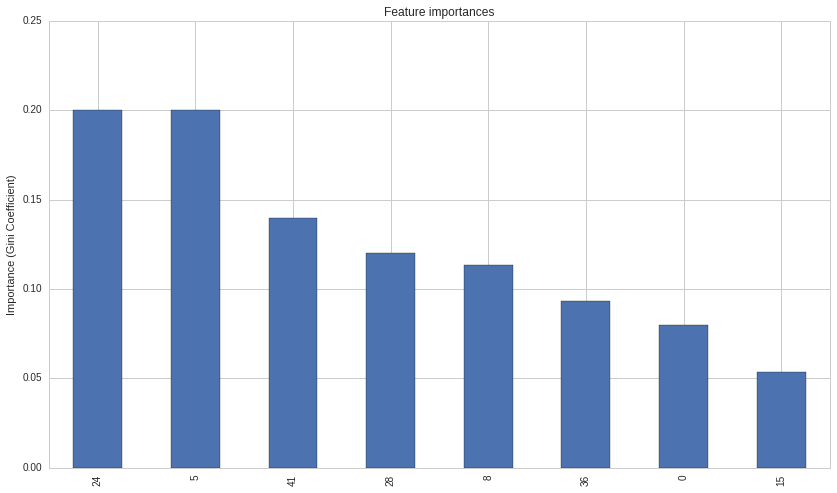

In [43]:
feature_importances.sort(ascending=False)
ax = feature_importances.plot(kind='bar')
ax.set(ylabel='Importance (Gini Coefficient)', title='Feature importances');

*Exercise*: Use [partial dependence plots](http://scikit-learn.org/stable/auto_examples/ensemble/plot_partial_dependence.html) to get an understanding of how factor rankings are used to predict future returns.

## Where to go from here
Several knobs can be tweaked to boost performance:

* Add existing factors from the collection above to the data set.
* Come up with new factors 
  * Use [`alphalens`](https://www.quantopian.com/posts/alphalens-a-new-tool-for-analyzing-alpha-factors) to evaluate an alpha for its predictive power.
  * Look for [novel data sources from our partners](https://www.quantopian.com/data).
  * Look at the [101 Alpha's Project](https://www.quantopian.com/posts/the-101-alphas-project).
* Improve preprocessing of the ML pipeline
  * Is 70/30 the best split? 
  * Should we not binarize the returns and do regression? 
  * Can we add Sector information in some way?
* Experiment with [feature selection](http://scikit-learn.org/stable/modules/feature_selection.html).
  * PCA
  * ICA
  * etc.
* Tweak hyper-parameters of `AdaBoostClassifier`.
  * [Use cross-validation to find optimal parameters](http://scikit-learn.org/stable/modules/grid_search.html).
* Try [different classifiers](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) of combinations of classifiers.

## Machine Learning competition
If you have something you think works well, post it in this thread. Make sure to test over the same time-period as I have here to keep things comparable. In a month from now, we can test on new data that has aggregated since then and determine who built the best ML pipeline. If there is demand, we might turn this into a proper ML contest.

## Machine Learning resources
If you look for information on how to get started with ML, here are a few resources:

* [Scikit-learn resources](http://scikit-learn.org/stable/presentations.html)
* [Learning scikit-learn: Machine Learning in Python](https://www.amazon.com/dp/1783281936)
* [Pattern Recognition and Machine Learning](https://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738)

## How to put this into an algorithm
As mentioned above, this is not immediately usable in an algorithm. For one thing, there is no `run_pipeline()` in the backtest IDE. It turns out to be rather simple to take the code above and put it into a pipeline `CustomFactor()` where the ML model would automatically get retrained and make predictions. You would then long the `1` predictions and short the `-1` predictions, apply some weighting (e.g. inverse variance) and execute orders. More on these next steps in the future.

## Credits
* Content created by James Christopher and Thomas Wiecki
* Thanks to Sheng Wang for ideas and inspiration.
* Jonathan Larkin, Jess Stauth, Delaney Granizo-Mackenzie, and Jean Bredeche for helpful comments on an earlier draft.